In [163]:
import numpy as np 
import pandas as pd 
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns; sns.set(color_codes=True)
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
from sklearn.cluster import KMeans
color = sns.color_palette()
from geopy.geocoders import Nominatim
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import descartes
import geopandas as gpd


ModuleNotFoundError: No module named 'geopandas'

In [135]:
def BairroLocalizator(coordinates):

    locator = Nominatim(user_agent='myGeocoder')
    coordinates = coordinates
    location = locator.reverse(coordinates)
    adress = location.address
    if len(adress.split(',')) == 11:
        county = adress.split(',')[2][1:]
    else:
        county = adress.split(',')[3][1:]

    return county



In [4]:
target = pd.read_csv('target_apartments.csv')
simulated = pd.read_csv('simulated_listings.csv')



In [5]:
target.columns


Index(['Unnamed: 0', 'rooms', 'garages', 'useful_area', 'latitude',
       'longitude', 'value', 'interior_quality'],
      dtype='object')

In [6]:
simulated.columns


Index(['Unnamed: 0', 'rooms', 'garages', 'useful_area', 'latitude',
       'longitude', 'value', 'interior_quality', 'time_on_market', 'sold'],
      dtype='object')

In [7]:
target.rename(columns={'Unnamed: 0':'Apartment_ID','rooms':'Rooms','garages':'Garage','useful_area':'Useful_Area','latitude':'Latitude','longitude':'Longitude', 'value':'Seller_Value','interior_quality':'Condition'},inplace=True)

target['Latitude'] = target['Latitude'].astype(str)
target['Longitude'] = target['Longitude'].astype(str)

target['Coordinates'] = target['Latitude'] + ', ' + target['Longitude']

simulated.rename(columns={'Unnamed: 0':'Apartment_ID','rooms':'Rooms','garages':'Garage','useful_area':'Useful_Area','latitude':'Latitude','longitude':'Longitude', 'value':'Market_Value','interior_quality':'Condition','time_on_market':'Time_on_Market', 'sold': 'Sold'},inplace=True)
simulated['Latitude'] = simulated['Latitude'].astype(str)
simulated['Longitude'] = simulated['Longitude'].astype(str)
simulated['Condition'] = simulated['Condition'].astype(str)

simulated['Coordinates'] = simulated['Latitude'] + ', ' + simulated['Longitude']


In [9]:
simulated.sort_values(['Time_on_Market','Sold'], axis = 0, ascending=True, inplace=True)

In [10]:
df_simulated = simulated.groupby('Sold')

In [155]:
sold = simulated.copy()
is_sold = sold['Sold']==1
sold = sold[is_sold]

selling = simulated.copy()
is_selling = selling['Sold']==0
selling = selling[is_selling]

In [109]:
top10_liquidity = sold.head(10)
bairro = []
for _, row in top10_liquidity.iterrows():
    bairro.append(BairroLocalizator(row['Coordinates']))
   

top10_liquidity['County'] = bairro
top10_liquidity.describe()

,Apartment_ID,Rooms,Garage,Useful_Area,Market_Value,Time_on_Market,Sold
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,6446.400,3.000,2.500,171.100,2171156.700,0.000,1.000
std,6646.679,0.667,1.434,124.411,2537954.826,0.000,0.000
min,436.000,2.000,1.000,75.000,750429.000,0.000,1.000
25%,1510.500,3.000,1.250,89.750,802564.250,0.000,1.000
50%,3321.500,3.000,2.000,108.000,994066.000,0.000,1.000
75%,10200.250,3.000,3.750,243.750,2262390.000,0.000,1.000
max,17470.000,4.000,5.000,430.000,8763840.000,0.000,1.000


In [111]:
tail10_liquidity = sold.tail(10)
bairro = []

for _, row in tail10_liquidity.iterrows():
    bairro.append(BairroLocalizator(row['Coordinates']))

tail10_liquidity['County'] = bairro
tail10_liquidity.describe()

,Apartment_ID,Rooms,Garage,Useful_Area,Market_Value,Time_on_Market,Sold
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,11111.900,2.900,2.300,164.700,1797383.700,171.500,1.000
std,4764.700,1.449,0.949,99.109,1287211.754,3.408,0.000
min,893.000,1.000,1.000,49.000,516948.000,167.000,1.000
25%,8678.250,1.250,2.000,99.250,926429.000,169.250,1.000
50%,12208.000,4.000,2.000,134.500,1397565.000,171.000,1.000
75%,14655.500,4.000,3.000,206.250,2123885.000,172.750,1.000
max,16323.000,4.000,4.000,360.000,4541930.000,177.000,1.000


In [25]:
conditions = sold['Condition'].value_counts()
size = conditions.tolist()

conditions = sold['Condition'].drop_duplicates()
conditions = conditions.tolist()

labels = conditions
sizes = size
explode = (0.1, 0, 0)


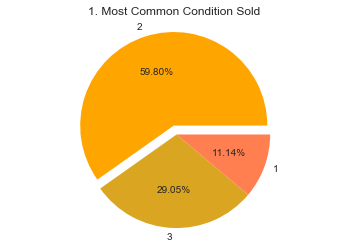

In [144]:
fig1, ax1 = plt.subplots()
ax1.pie(size, explode=explode, labels=labels, autopct='%1.2f%%', shadow=False, startangle=360, colors=['orange', 'goldenrod', 'coral'])
ax1.axis('equal') 
plt.title('1. Most Common Condition Sold')
conditions_chart = plt.show()
conditions_chart

In [116]:
sold_cross = pd.crosstab(sold['Condition'], sold['Rooms'])
sold_cross['Total'] = sold_cross.sum(axis=1)
sold_cross['% Apartment'] = sold['Condition'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
sold_cross

Rooms,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,Total,% Apartment
Condition,,,,,,,,,,
1,45,130,233,134,9,1,0,0,552,11.1%
2,108,354,576,390,9,0,1,1,1439,29.1%
3,214,696,1208,816,26,2,0,0,2962,59.8%


In [125]:
sold.describe()

,Apartment_ID,Rooms,Garage,Useful_Area,Market_Value,Time_on_Market,Sold
count,4953.000,4953.000,4953.000,4953.000,4953.000,4953.000,4953.000
mean,9052.637,2.906,2.194,164.189,1920183.793,43.045,1.000
std,5179.702,0.920,1.323,124.223,2184736.526,35.436,0.000
min,2.000,1.000,1.000,27.000,220212.000,0.000,1.000
25%,4502.000,2.000,1.000,80.000,767777.000,15.000,1.000
50%,9137.000,3.000,2.000,127.000,1263370.000,34.000,1.000
75%,13580.000,4.000,3.000,206.000,2199480.000,63.000,1.000
max,17927.000,8.000,14.000,1281.000,36925000.000,177.000,1.000


In [165]:
trace1 = go.Box(y = sold.loc[sold['Rooms'] == 1, 'Market_Value'],
                name = '"Apê" 1 Rooms',
                marker = {'color': '#f39c12'})
trace2 = go.Box(y = sold.loc[sold['Rooms'] == 2, 'Market_Value'],
                name = '"Apê" 2 Rooms',
                marker = {'color': '#e67e22'})
trace3 = go.Box(y = sold.loc[sold['Rooms'] == 3, 'Market_Value'],
                name = '"Apê" 3 Rooms',
                marker = {'color': '#d35400'})
trace4 = go.Box(y = sold.loc[sold['Rooms'] == 4, 'Market_Value'],
                name = '"Apê" 4 Rooms',
                marker = {'color': '#ea8685'})
trace5 = go.Box(y = sold.loc[sold['Rooms'] == 5, 'Market_Value'],
                name = '"Apê" 5 Rooms',
                marker = {'color': '#f19066'})
trace8 = go.Box(y = sold.loc[sold['Rooms'] == 8, 'Market_Value'],
                name = '"Apê" 8 Rooms',
                marker = {'color': '#f3a683'})

data = [trace1, trace2, trace3, trace4, trace5, trace8]
layout = go.Layout(title = 'Price dispersion for houses with different rooms',
                   titlefont = {'family': 'Arial',
                                'size': 22,
                                'color': '#7f7f7f'},
                   xaxis = {'title': 'Rooms'},
                   yaxis = {'title': 'Price'},
                   paper_bgcolor = 'rgb(243, 243, 243)',
                   plot_bgcolor = 'rgb(243, 243, 243)')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [157]:
conditions_sold = sold['Condition'].value_counts()
size_sold = conditions_sold.tolist()

conditions_sold = sold['Condition'].drop_duplicates()
conditions_sold = conditions_sold.tolist()

labels_sold = conditions_sold
sizes_sold = size_sold


conditions_selling = selling['Condition'].value_counts()
size_selling = conditions_selling.tolist()

conditions_selling = selling['Condition'].drop_duplicates()
conditions_selling = conditions_selling.tolist()

labels_selling = conditions_selling
sizes_selling = size_selling


[2734, 959, 320]

In [164]:
trace1 = go.Bar(x = labels_sold,
                y = size_sold,
                name = '"Apê" Sold',
                marker = {'color': '#feca57'})

trace2 = go.Bar(x = labels_selling,
                y = sizes_selling,
                name = '"Apê" Selling',
                marker = {'color': '#ff9f43'})

data = [trace1, trace2]
layout = go.Layout(title = 'Relationship Between Sold and Selling based on Condition',
                   xaxis = {'title': 'Condition'},
                   yaxis = {'title': '# of Apartments'},
                   barmode = 'stack')
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)